# Oxford Pets - Multiclass Classification

## Modules

In [1]:
import os
import sys

common_dir = os.path.abspath("../../common")
print(os.listdir(common_dir))

if common_dir not in sys.path:
    sys.path.append(common_dir)

['pt_trainer.py', 'tf_trainer.py', 'utils.py', '__pycache__']


In [2]:
import torch
import torch.nn as nn
import torchvision

import random
import numpy as np
import matplotlib.pyplot as plt

from utils import show_images, plot_progress
from pt_trainer import TrainerWithMetrics, TrainerWithEarlyStopping
from pt_trainer import accuracy, binary_accuracy
from scipy.special import softmax, expit as sigmoid

## Parameters

In [3]:
use_cpu = False
use_cuda = not use_cpu and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed_all(seed)

cuda


In [4]:
image_size = (224, 224)
batch_size = 30

In [5]:
save_weights = False
weights_name = "./pt_models/pt_oxford-pets_clf-37.pth"

## Data Set

In [6]:
from glob import glob
import re
from sklearn.preprocessing import LabelEncoder
from collections import Counter

def get_paths(image_dir, formats=["*"]):
    invalid_images = ['Egyptian_Mau_14',  'Egyptian_Mau_139', 'Egyptian_Mau_145',
                      'Egyptian_Mau_156', 'Egyptian_Mau_167', 'Egyptian_Mau_177',
                      'Egyptian_Mau_186', 'Egyptian_Mau_191', 'Abyssinian_5',
                      'Abyssinian_34',    'chihuahua_121',    'beagle_116']
    paths = []
    for ext in formats:
        paths += glob(os.path.join(image_dir, f"*.{ext}"))

    valid_paths = []
    for path in paths:
        image_name = os.path.basename(path).split('.')[0]
        if image_name not in invalid_images:
            valid_paths.append(path)
    return valid_paths


def get_labels(image_paths, n_classes=37):
    image_names = [os.path.basename(path).split('.')[0] for path in image_paths]
    if n_classes == 2:
        labels = ['cat' if name[0].isupper() else 'dog' for name in image_names]
    else:
        labels = [re.sub('_\d+', '', name) for name in image_names]
    return labels

def get_class_names(labels):
    return list(Counter(labels).keys())

def label_encoder(labels, class_names):
    encoder = {name: i for i, name in enumerate(class_names)}
    return [encoder[label] for label in labels]

In [7]:
import xml.etree.ElementTree as et

def change_paths(new_dir, old_paths, replace=("ext1", "ext2")):
    filenames = [os.path.basename(path).replace(replace[0], replace[1])
                 for path in old_paths]
    return [os.path.join(new_dir, name) for name in filenames]

def get_bboxes(bbox_paths):
    bboxes = []
    for path in bbox_paths:
        tree = et.parse(path)

        width = float(tree.find('./size/width').text)
        height = float(tree.find('./size/height').text)
        xmin = float(tree.find('./object/bndbox/xmin').text)
        xmax = float(tree.find('./object/bndbox/xmax').text)
        ymin = float(tree.find('./object/bndbox/ymin').text)
        ymax = float(tree.find('./object/bndbox/ymax').text)

        x = (xmax + xmin)/width/2
        y = (ymax + ymin)/height/2
        w = (xmax - xmin)/width
        h = (ymax - ymin)/height
        bboxes.append([x, y, w, h])
    return bboxes

In [8]:
data_dir = "/mnt/f/deep_learning/datasets/oxford_pets_783M/"
image_dir = os.path.join(data_dir, "images")
bbox_dir = os.path.join(data_dir, "annotations", "xmls")

bbox_paths = get_paths(bbox_dir, formats=['xml'])
image_paths = change_paths(image_dir, bbox_paths, replace=['xml', 'jpg'])
labels = get_labels(bbox_paths, n_classes=37)
class_names = get_class_names(labels)
labels = label_encoder(labels, class_names)

print(f">> Images: {len(bbox_paths)}")
print(">> Class Names:", class_names)

>> Images: 3684
>> Class Names: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [9]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, stratify=labels, train_size=0.8, random_state=seed)

train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(
    train_image_paths, train_labels, stratify=train_labels, train_size=0.75, random_state=seed)

train_bbox_paths = change_paths(bbox_dir, train_image_paths, replace=['jpg', 'xml'])
valid_bbox_paths = change_paths(bbox_dir, valid_image_paths, replace=['jpg', 'xml'])
test_bbox_paths = change_paths(bbox_dir, test_image_paths, replace=['jpg', 'xml'])

train_bboxes = get_bboxes(train_bbox_paths)
valid_bboxes = get_bboxes(valid_bbox_paths)
test_bboxes = get_bboxes(test_bbox_paths)

n_images = len(image_paths)
print(f">> Train images: {len(train_image_paths)} ({len(train_image_paths)/n_images:.2f})")
print(f">> Valid images: {len(valid_image_paths)} ({len(valid_image_paths)/n_images:.2f})")
print(f">> Test  images: {len(test_image_paths)} ({len(test_image_paths)/n_images:.2f})")

>> Train images: 2210 (0.60)
>> Valid images: 737 (0.20)
>> Test  images: 737 (0.20)


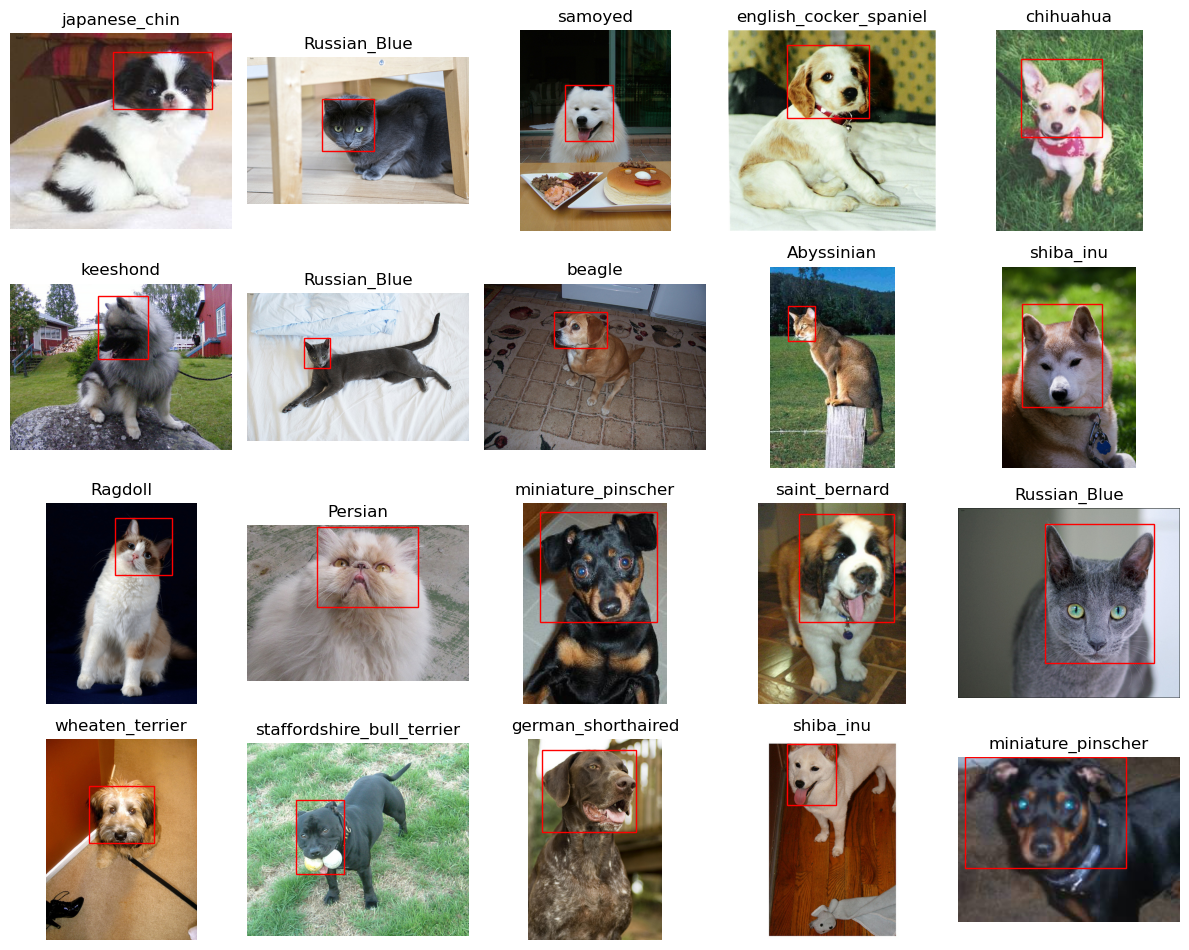

In [10]:
n_samples = 20
show_images(train_image_paths[:n_samples], labels=train_labels[:n_samples],
            bboxes=train_bboxes[:n_samples], class_names=class_names)

## Data Loader

In [11]:
# import cv2
# import albumentations as A

# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, image_paths, bboxes, labels, training=False):
#         super().__init__()
#         self.image_paths = image_paths
#         self.bboxes = bboxes
#         self.labels = labels
#         self.transform = train_transform if training else valid_transform
        
#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image = cv2.imread(self.image_paths[idx])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         bbox = self.bboxes[idx]
#         label = self.labels[idx]
       
#         transformed = self.transform(image=image, bboxes=[bbox], labels=[label])
#         image = transformed["image"]
#         bbox = transformed['bboxes'][0]     # tuple
#         label = transformed['labels'][0]    # not tuple
#         bbox_label = bbox + (label,)
        
#         image = torch.tensor(image).permute(2, 0, 1).float()/255
#         # image = torch.tensor(image).permute(2, 0, 1).float()
#         bbox_label = torch.tensor(bbox_label).float()
#         return image, bbox_label


# train_transform = A.Compose([
#     A.Resize(height=image_size[0], width=image_size[1]),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     # A.ShiftScaleRotate(p=0.5, shift_limit=0.05, scale_limit=0.05, rotate_limit=15,),
#     # A.CoarseDropout(p=0.5, max_holes=8, max_height=int(0.1*image_size[0]), 
#     #                 max_width=int(0.1*image_size[1])),
#     # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#     ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))
# valid_transform = A.Compose([
#     A.Resize(height=image_size[0], width=image_size[1]),
#     # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#     ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))

# train_loader = torch.utils.data.DataLoader(
#         Dataset(train_image_paths, train_bboxes, train_labels, training=True), 
#         batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
# valid_loader = torch.utils.data.DataLoader(
#         Dataset(valid_image_paths, valid_bboxes, valid_labels, training=False), 
#         batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(
#         Dataset(test_image_paths, test_bboxes, test_labels, training=False), 
#         batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [12]:
# images, bboxes_labels = next(iter(train_loader))
# print(type(images), images.shape, images.dtype)
# print(type(bboxes_labels), bboxes_labels.shape, bboxes_labels.dtype)

# images = images.permute(0, 2, 3, 1).numpy().astype(int)
# bboxes_labels = bboxes_labels.numpy()
# bboxes, labels = bboxes_labels[:, :4], bboxes_labels[:, 4:]

# n_samples = 20
# print(f">> Images: min: {images.min()}, max: {images.max()}")
# print(f">> BBoxes: min: {bboxes.min()}, max: {bboxes.max()}")
# print(f">> Labels: min: {labels.min()}, max: {labels.max()}")
# show_images(images[:n_samples], labels=labels[:n_samples], 
#             class_names=class_names, bboxes=bboxes[:n_samples])

In [13]:
from torchvision import transforms
import PIL

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, paths, bboxes, labels, transform=None):
        super().__init__()
        self.paths, self.labels, self.bboxes = paths, labels, bboxes
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        image = PIL.Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        bbox = self.bboxes[idx]
        label = self.labels[idx]
        bbox_label = torch.tensor(bbox + [label]).float()
        return image, bbox_label

input_shape = (3, 224, 224)
kwargs = {'num_workers': 8, 'pin_memory': True}

train_transform = transforms.Compose([
    transforms.Resize(input_shape[1:]),
    transforms.ToTensor(),
])
valid_transform = transforms.Compose([
    transforms.Resize(input_shape[1:]),
    transforms.ToTensor(),
])

train_loader = torch.utils.data.DataLoader(
    dataset=ImageDataset(train_image_paths, train_bboxes, train_labels,
                         transform=train_transform),
    batch_size=batch_size, shuffle=True, **kwargs)

valid_loader = torch.utils.data.DataLoader(
    dataset=ImageDataset(valid_image_paths, valid_bboxes, valid_labels,
                         transform=valid_transform),
    batch_size=batch_size, shuffle=False, **kwargs)

<class 'torch.Tensor'> torch.Size([30, 3, 224, 224]) torch.float32
<class 'torch.Tensor'> torch.Size([30, 5]) torch.float32
>> Images: min: 0.0, max: 1.0
>> BBoxes: min: 0.14425428211688995, max: 0.9071856141090393
>> Labels: min: 0.0, max: 34.0


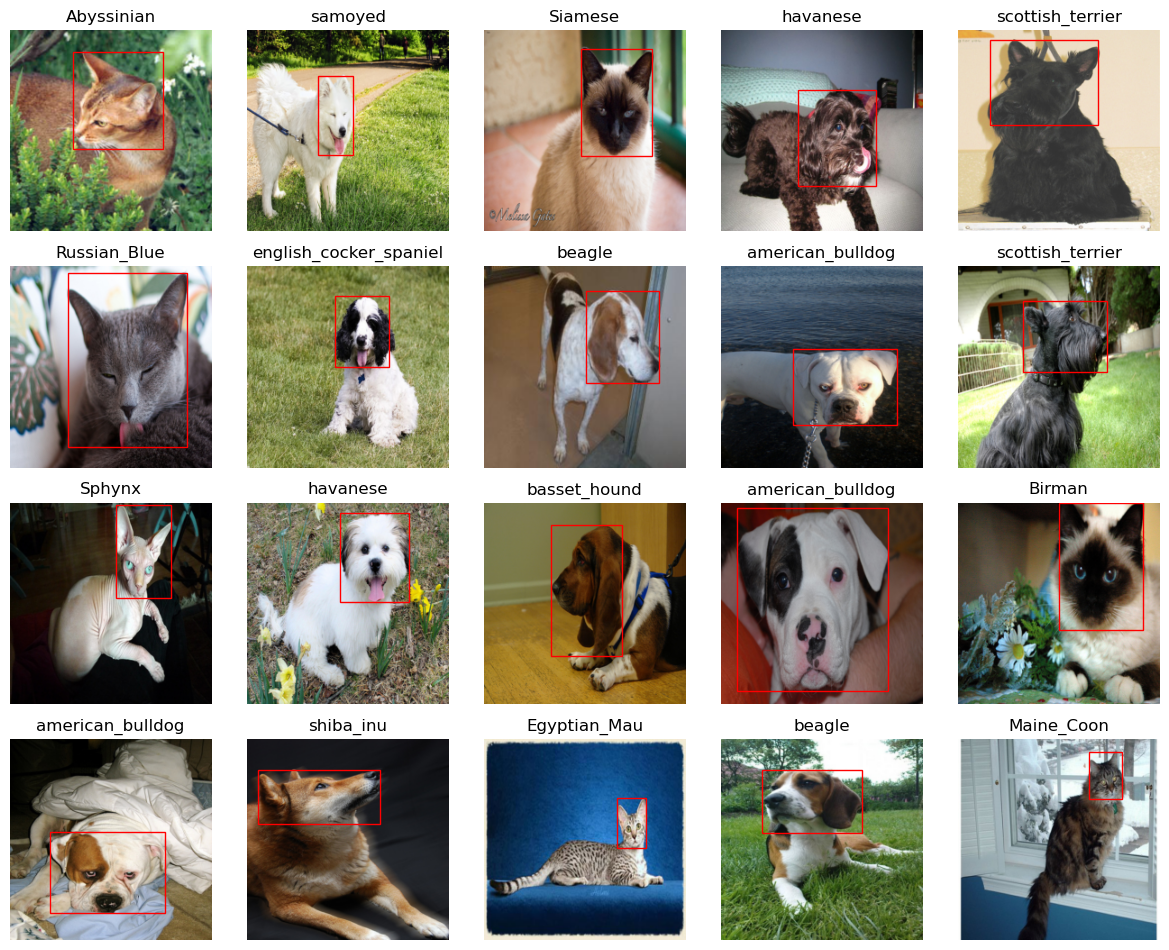

In [14]:
images, bboxes_labels = next(iter(train_loader))
print(type(images), images.shape, images.dtype)
print(type(bboxes_labels), bboxes_labels.shape, bboxes_labels.dtype)

images = images.permute(0, 2, 3, 1).numpy()
bboxes_labels = bboxes_labels.numpy()
bboxes, labels = bboxes_labels[:, :4], bboxes_labels[:, 4:]

n_samples = 20
print(f">> Images: min: {images.min()}, max: {images.max()}")
print(f">> BBoxes: min: {bboxes.min()}, max: {bboxes.max()}")
print(f">> Labels: min: {labels.min()}, max: {labels.max()}")
show_images(images[:n_samples], labels=labels[:n_samples], 
            class_names=class_names, bboxes=bboxes[:n_samples])

### Modeling

In [15]:
# print(torch.__version__)
# print(torchvision.__version__)
# dir(torchvision.models)

In [16]:
# from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
# from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

# pretrained_models = {'efficientnetv2': efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT),
#                      'mobilenetv3': mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)}
# n_features = {'efficientnetv2': 1280, 'mobilenetv3': 960}

# class PretrainedModel(nn.Module):
#     def __init__(self, model_name, n_classes, freezed=True):
#         super().__init__()
#         base_model = pretrained_models[model_name]
#         for param in base_model.parameters():
#             param.requires_grad = not freezed

#         self.n_features = n_features[model_name]
#         self.features = base_model.features
#         self.avgpool = base_model.avgpool

#         ## Localization
#         self.fc1 = nn.Sequential(
#             nn.Dropout(0.2),
#             nn.Linear(self.n_features, 256),
#             nn.ReLU(),
#             nn.Linear(256, 4),)
#             # nn.Sigmoid(),)
        
#         ## Classification
#         self.fc2 = nn.Sequential(
#             nn.Dropout(0.2),
#             nn.Linear(self.n_features, 256),
#             nn.ReLU(),
#             nn.Linear(256, n_classes),)
    
#     def forward(self, inputs):
#         x = self.features(inputs)
#         avg = self.avgpool(x).view(-1, self.n_features)
#         outputs = torch.cat([self.fc1(avg), self.fc2(avg)], dim=1)
#         return outputs

In [17]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

pretrained_models = {'efficientnetv2': efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT),
                     'mobilenetv3': mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)}
n_features = {'efficientnetv2': 1280, 'mobilenetv3': 960}


class PretrainedModel(nn.Module):
    def __init__(self, n_classes, freezed=True):
        super().__init__()
        base_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
        for param in base_model.features.parameters():
            param.requires_grad = not freezed
        
        self.n_features = 1280*7*7
        self.features = base_model.features

        ## Localization: [x, y, w, h]
        self.fc1 = nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(self.n_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Sigmoid()
        )

        ## Multiclass classification
        self.fc2 = nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(self.n_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, n_classes),
        )        

    def forward(self, inputs):
        x = self.features(inputs)
        avg = x.view(-1, self.n_features)
        outputs = torch.cat([self.fc1(avg), self.fc2(avg)], dim=1)
        return outputs

In [18]:
def mse_loss(y_pred, y_true):
    y_pred, y_true = y_pred[:, :4], y_true[:, :4]
    loss_fn = nn.MSELoss()
    return 10*loss_fn(y_pred, y_true)

def ce_loss(y_pred, y_true):
    y_pred = y_pred[:, 4:], y_true[:, 4:].squeeze().long()
    loss_fn = nn.CrossEntropyLoss()
    return loss_fn(y_pred, y_true)

def mse_ce_loss(y_pred, y_true):
    return mse_loss(y_pred, y_true) + ce_loss(y_pred, y_true)

def acc(y_pred, y_true):
    y_pred, y_true = y_pred[:, 4:], y_true[:, 4:].squeeze().long()
    y_pred = y_pred.argmax(dim=1)
    return torch.eq(y_pred, y_true).float().mean()

def iou(box1, box2):
    x1, y1, w1, h1 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    x2, y2, w2, h2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    inter_w = torch.minimum(x1 + w1/2, x2 + w2/2) - torch.maximum(x1 - w1/2, x2 - w2/2)
    inter_h = torch.minimum(y1 + h1/2, y2 + h2/2) - torch.maximum(y1 - h1/2, y2 - h2/2)
    intersection = torch.maximum(inter_w, torch.zeros_like(inter_w)) \
                    * torch.maximum(inter_h, torch.zeros_like(inter_h))
    iou = intersection / (w1*h1 + w2*h2 - intersection)
    return iou.mean()

## Training

In [19]:
%%time
## Feature Extraction

model = PretrainedModel(n_classes=37, freezed=True).to(device)
# model = PretrainedModel('efficientnetv2', n_classes=37, freezed=True).to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = mse_loss
metrics = {'iou': iou, 'acc': acc}

clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
hist = clf.fit(train_loader, n_epochs=5, valid_loader=valid_loader)

Epoch[  1/  5] loss=0.2152, iou=0.3878, acc=0.0270 | val_loss=0.1340, val_iou=0.4762, val_acc=0.0240 (1)
Epoch[  2/  5] loss=0.0865, iou=0.5265, acc=0.0230 | val_loss=0.1139, val_iou=0.5079, val_acc=0.0253 (1)
Epoch[  3/  5] loss=0.0620, iou=0.5707, acc=0.0264 | val_loss=0.1058, val_iou=0.5171, val_acc=0.0264 (1)
Epoch[  4/  5] loss=0.0496, iou=0.6013, acc=0.0291 | val_loss=0.1010, val_iou=0.5245, val_acc=0.0250 (1)
Epoch[  5/  5] loss=0.0437, iou=0.6129, acc=0.0261 | val_loss=0.0990, val_iou=0.5192, val_acc=0.0290 (1)
CPU times: user 40.4 s, sys: 6.78 s, total: 47.2 s
Wall time: 46.1 s


In [ ]:
# %%time
# ## Feature Extraction

# model = PretrainedModel('efficientnetv2', n_classes=37, freezed=True).to(device)
# optimizer = torch.optim.Adam(model.parameters())
# loss_fn = mse_loss
# metrics = {'iou': iou}

# clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
# clf.fit(train_loader, n_epochs=100, valid_loader=valid_loader)

# results = clf.evaluate(test_loader)
# print(">>", ', '.join([f"test_{key}={value:.4f}" 
#                        for key, value in results.items()]))

In [ ]:
%%time
## Feature Extraction

model = PretrainedModel(n_classes=37, freezed=True).to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = mse_ce_loss
metrics = {'mse': mse_loss, 'ce': ce_loss, 'iou': iou, 'acc': acc}

clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
hist = clf.fit(train_loader, n_epochs=100, valid_loader=valid_loader)

In [ ]:
# if save_weights:
#     torch.save(model, weights_name)

## Inference

In [ ]:
# if save_weights:
#     model = get_pretrained_model('efficientnetv2', n_classes=37, freezed=True).to(device)
#     model.load_state_dict(torch.load(weights_name))

In [ ]:
images, bboxes_labels = next(iter(valid_loader))

model.eval()
preds = model(images.to(device)).detach().cpu()

images = images.permute(0, 2, 3, 1).numpy()
bboxes_labels = bboxes_labels.numpy()
bboxes, labels = bboxes_labels[:, :4], bboxes_labels[:, 4:]

preds = preds.numpy()
pred_bboxes, pred_labels = preds[:, :4], preds[:, 4:].argmax(axis=-1)

n_samples = 10
print(f">> Ground Truth:")
show_images(images[:n_samples], labels=labels[:n_samples], 
            class_names=class_names, bboxes=bboxes[:n_samples])

print(f">> Predictions:")
show_images(images[:n_samples], labels=pred_labels[:n_samples], 
            class_names=class_names, bboxes=pred_bboxes[:n_samples], bbox_color='b',
            bboxes2=bboxes[:n_samples], bbox_color2='r')